## Preliminaries and Setup

#### Import necessary moduels

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt
import axs
import pyspark.sql.functions as sparkfunc
import dipper
from pyspark.sql import SparkSession

%matplotlib notebook
%matplotlib inline

#### Define functions used in this notebook

In [18]:
def top_hat(x, loc, width, depth, offset):
    import numpy as np
    x = np.array(x)
    left = loc - width / 2
    right = loc + width / 2
    outside = (x < left) | (x > right)
    inside = np.logical_not(outside)
    
    y = np.zeros(x.shape)
    y[outside] = offset
    y[inside] = offset + depth
    
    return y

In [3]:
def plot_cuts(lst, temp_df):
    for item in lst:
        row = temp_df[temp_df['ps1_objid']==item].iloc[0] 
        plot_top_hat_row(row)

In [4]:
def plot_top_hat_row(row):
    dip = row['dip']

    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    window_r = row['window_r']
    plt.errorbar(row['mjd_r'], row['mag_r'], row['magerr_r'], fmt='o', c='C3')
    
    
    start_mjd = dip['window_start_mjd']
    end_mjd = dip['window_end_mjd']
    pad = end_mjd - start_mjd
    
    plt.axvline(start_mjd, c='k', ls='--')
    plt.axvline(end_mjd, c='k', ls='--')
    
    plt.xlim(start_mjd - pad, end_mjd + pad)
    popt = [float(i) for i in row['fit_r']['popt']]
    x = np.linspace(start_mjd - pad, end_mjd + pad, 1000)
    model = top_hat(x, *popt)
    plt.plot(x, model, label=f'Top hat fit - {row["dip"]["significance"]}')
    

    ax.set_xlabel('MJD')
    ax.set_title('objid %d' % row['ps1_objid'])
    plt.gca().invert_yaxis()
    plt.legend()
    print(row['ps1_objid'])
    print(f'top hat fit: {row["dip"]["significance"]}')
    print(f'length: {popt[1]}')
    print()

#### Load Steven's data

In [5]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

In [6]:
#load the data from the catalog
catalog = axs.AxsCatalog(spark_session)
spark_session

In [ ]:
Select the best dips 

In [7]:
#for top-hat fits
top_hat = catalog.load("8_5_20_stevengs_top_hat_fits_r_band")

In [ ]:
# Select the good dippers with a set of cuts tuned to
# pull out what we are looking for.
cut_wtf = (
    wtf
    .where(
        (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.significant_observation_count") >= 3)
        
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
        
        & (sparkfunc.col("dip.core_length") >= 15)
        & (sparkfunc.col("dip.core_not_significant_fraction") < 0.2)
        & (sparkfunc.col("dip.core_significant_count") > 3.)

        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        & (sparkfunc.col("dip.ref_length_fraction_before") > 0.2)
        & (sparkfunc.col("dip.ref_length_fraction_after") > 0.2)
    )
)
best_dippers = cut_wtf.sort(cut_wtf['dip.significance'].desc()).head(1000)

## EDA

In [8]:
df_top_hat = top_hat.toPandas()

In [9]:
df_top_hat.head()

,ps1_objid,ra,dec,zone,dup,mjd_r,mag_r,magerr_r,dip,window_r,fit_r,dip_window_r,model_error_in_dip_r,around_dip_window_r,model_error_around_dip_r,model_error_r
0,88492547744402750,254.774445,-16.256347,4424,0,"[58289.296701411105, 58505.56163191111, 58289....","[14.18539047241211, 14.21023941040039, 14.1802...","[0.008864653296768665, 0.008924957364797592, 0...","(58282.18359375, 58271.09765625, 58293.7070312...","([58289.296875, 58289.296875, 58289.296875, 58...","((OK, True, 0.0009300708770751953), [58282.402...","([58289.296875, 58289.296875, 58289.296875, 58...","(247.6127166748047, 1.0672962665557861)","([58289.296875, 58289.296875, 58289.296875, 58...","(394.15240478515625, 1.6354870796203613)","(2046.572509765625, 4.5887274742126465)"
1,88492616365368548,261.636494,-16.251513,4424,0,"[58694.26563661111, 58694.266076411106, 58694....","[19.338125228881836, 19.897186279296875, 19.49...","[0.07690298557281494, 0.10945793241262436, 0.0...","(58668.19140625, 58654.1796875, 58686.78515625...","([58694.265625, 58694.265625, 58694.296875, 58...","((OK, True, 0.0009021759033203125), [58670.484...","([58658.25390625, 58658.25390625, 58658.273437...","(923.65087890625, 5.920839309692383)","([58694.265625, 58694.265625, 58694.296875, 58...","(1042.3411865234375, 5.855849742889404)","(1082.382568359375, 5.696750640869141)"
2,88492647084704897,264.708448,-16.254534,4424,0,"[58668.269270811106, 58668.26972221111, 58217....","[18.694232940673828, 18.403799057006836, 18.49...","[0.05746031180024147, 0.04840732365846634, 0.0...","(58665.94140625, 58645.3828125, 58682.37890625...","([58668.26953125, 58668.26953125, 58669.21875,...","((OK, True, 0.0009152889251708984), [58663.882...","([58668.26953125, 58668.26953125, 58669.21875,...","(668.8413696289062, 4.371512413024902)","([58668.26953125, 58668.26953125, 58669.21875,...","(867.9769287109375, 4.903824329376221)","(893.7521362304688, 4.831092357635498)"
3,88502659022770783,265.902111,-16.249697,4424,1,"[58723.210879611106, 58662.25165511111, 58723....","[20.32710075378418, 20.458742141723633, 20.163...","[0.13722196221351624, 0.13952502608299255, 0.1...","(58669.66015625, 58656.98046875, 58684.2460937...","([58723.2109375, 58662.25, 58723.2109375, 5866...","((OK, True, 0.0011773109436035156), [58670.613...","([58662.25, 58662.26953125, 58662.28125, 58662...","(290.2123107910156, 2.638293743133545)","([58723.2109375, 58662.25, 58723.2109375, 5866...","(726.5582275390625, 3.823990821838379)","(781.9889526367188, 3.8904924392700195)"
4,88492659738601532,265.973936,-16.257403,4424,0,"[58640.27548611111, 58338.19006941111, 58643.2...","[19.86772346496582, 20.279481887817383, 20.164...","[0.11113061755895615, 0.1357736587524414, 0.13...","(58678.40234375, 58635.7734375, 58706.1484375,...","([58640.27734375, 58643.2734375, 58646.2734375...","((OK, True, 0.0008547306060791016), [58670.960...","([58640.27734375, 58643.2734375, 58646.2734375...","(804.3997802734375, 9.930861473083496)","([58640.27734375, 58643.2734375, 58646.2734375...","(832.2371215820312, 9.247078895568848)","(854.6178588867188, 8.632503509521484)"


In [10]:
df_top_hat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71764 entries, 0 to 71763
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ps1_objid                 71764 non-null  int64  
 1   ra                        71764 non-null  float64
 2   dec                       71764 non-null  float64
 3   zone                      71764 non-null  int64  
 4   dup                       71764 non-null  int32  
 5   mjd_r                     71764 non-null  object 
 6   mag_r                     71764 non-null  object 
 7   magerr_r                  71764 non-null  object 
 8   dip                       71764 non-null  object 
 9   window_r                  71764 non-null  object 
 10  fit_r                     71764 non-null  object 
 11  dip_window_r              71764 non-null  object 
 12  model_error_in_dip_r      71764 non-null  object 
 13  around_dip_window_r       71764 non-null  object 
 14  model_

## Prep and cuts for top-hat fits

In [66]:
# Sort by significance
sig = [i['significance'] for i in df_top_hat['dip']]
df_top_hat = df_top_hat.iloc[np.argsort(sig)]

In [67]:
# Steven's definitions
# width of the dip
xscale = np.array([i['popt'][1] for i in df_top_hat["fit_r"]])
# depth of the dip
yscale = np.array([i['popt'][2] for i in df_top_hat["fit_r"]])

#Kyle's definition --- must speak with him to find out how this works
#top_hat_value = np.array([i['significance'] for i in sig_df_top_hat['dip']])

In [68]:
# TO DO: define magic numbers

def top_hat_cut(start_days, end_days, depth, min_ysacle=0.5):
    cut = (
        (np.abs(xscale) > start_days)
        & (np.abs(xscale) < end_days)
        & (np.abs(yscale) < depth)
        & (yscale > min_ysacle)
    )
    return cut

In [75]:
# Already checked:
# start_days=30, end_days=50, depth=5, np.abs(yscale) > .5

cut_top_hat = top_hat_cut(start_days=10, end_days=50, depth=5)

In [76]:
top_hat_total = np.sum(cut_top_hat)
print(f'the number of tophats for this cut: {top_hat_total}')

the number of tophats for this cut: 35


143703052402809445
top hat fit: 5.032649993896484
length: 17.90625

133633006803984748
top hat fit: 5.093222141265869
length: 45.7265625

134932890028931796
top hat fit: 5.175656795501709
length: 17.1640625

141172960519494265
top hat fit: 5.176199913024902
length: 13.5078125

149773135821827367
top hat fit: 5.323555946350098
length: 21.6015625

90332670646711140
top hat fit: 5.442981719970703
length: 32.41015625

147382950263552725
top hat fit: 5.480869293212891
length: 10.70703125

147382950263552725
top hat fit: 5.480869293212891
length: 10.70703125

149242869031049155
top hat fit: 5.515087127685547
length: 12.82421875

126762958386870517
top hat fit: 5.821953773498535
length: 11.9609375

142002935507528260
top hat fit: 6.11067533493042
length: 11.5859375

110752895720964770
top hat fit: 6.166559219360352
length: 10.76171875

97221050498067526
top hat fit: 6.35344123840332
length: 49.84375

143872865792354634
top hat fit: 6.359478950500488
length: 12.34375

170802190853737493
top ha

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

146423019301802432
top hat fit: 11.772953987121582
length: 16.2890625

146423019301802432
top hat fit: 11.772953987121582
length: 16.2890625

181363543950526797
top hat fit: 12.41705322265625
length: 19.8515625

106652820419330544
top hat fit: 12.623050689697266
length: 14.1953125

182263487736887612
top hat fit: 13.07863712310791
length: 25.36328125

136542951034326590
top hat fit: 15.95946979522705
length: 23.671875

89662576081054444
top hat fit: 17.963314056396484
length: 14.03125

93622748990865634
top hat fit: 19.340959548950195
length: 16.44140625



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed 

138752948842710280
top hat fit: 19.37936782836914
length: 27.8671875

108702869078276793
top hat fit: 23.084095001220703
length: 48.74609375

108702869079236459
top hat fit: 23.084095001220703
length: 48.74609375

119682858676508991
top hat fit: 36.44206237792969
length: 22.84375



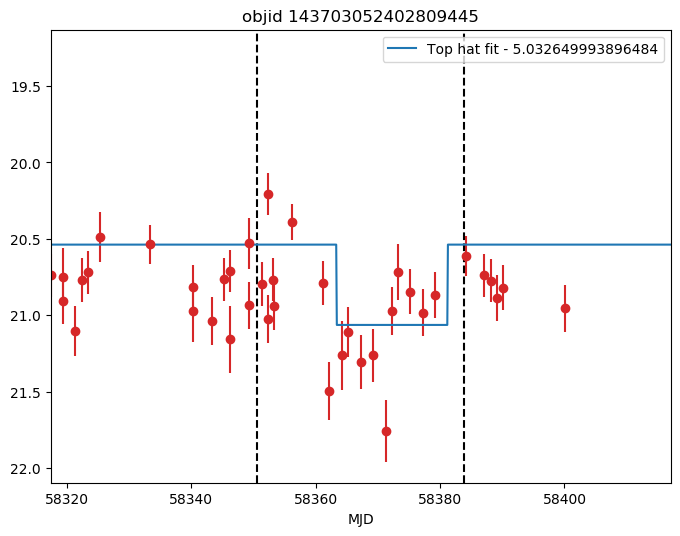

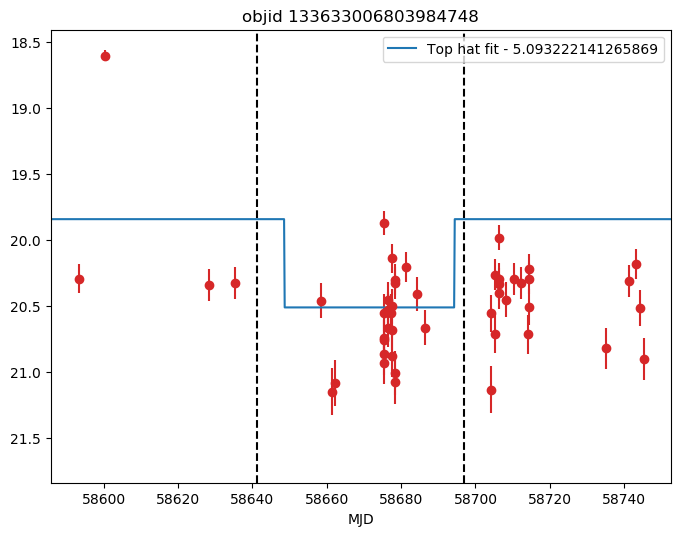

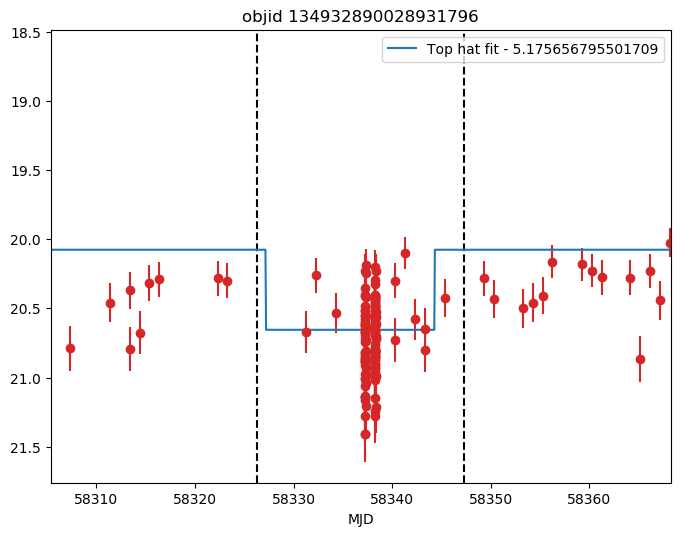

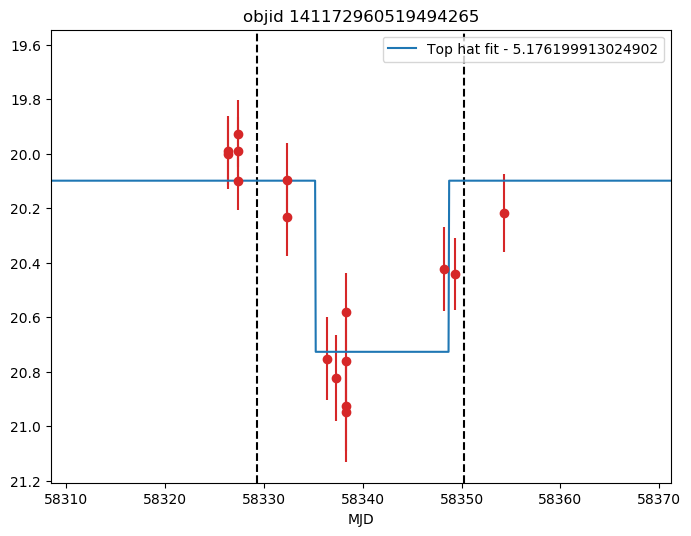

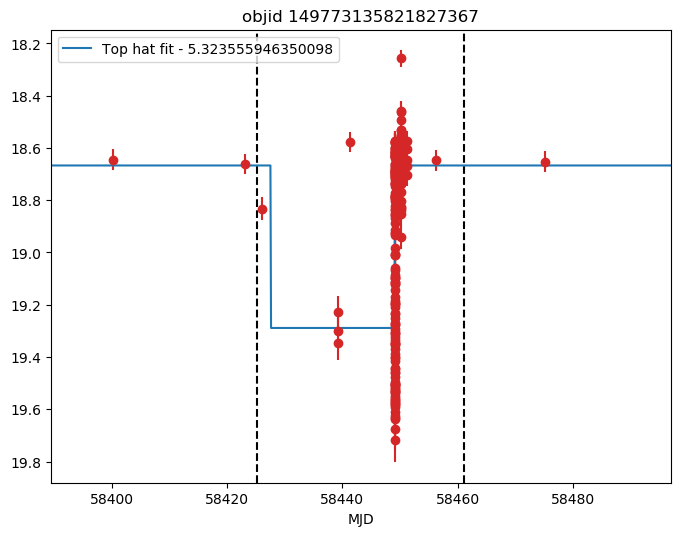

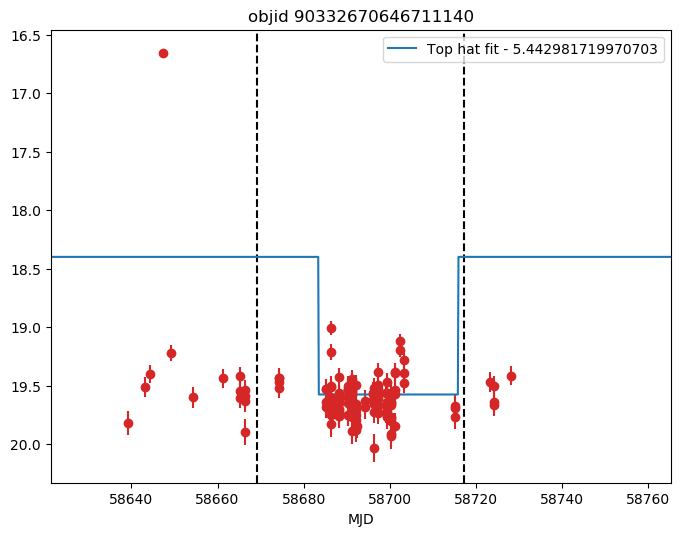

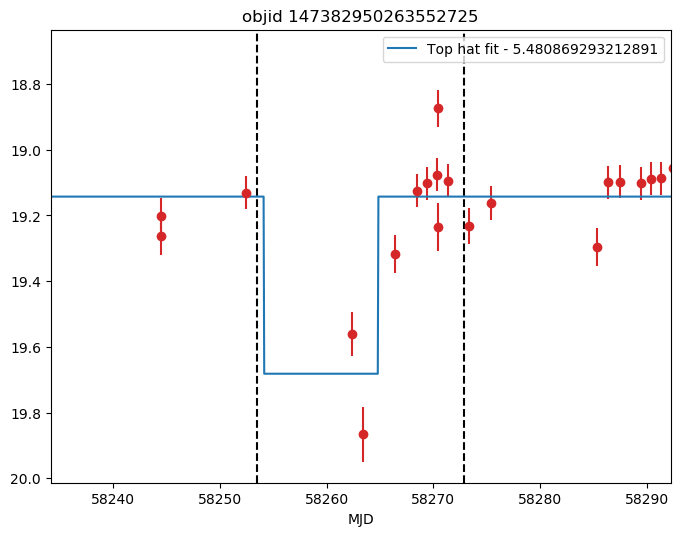

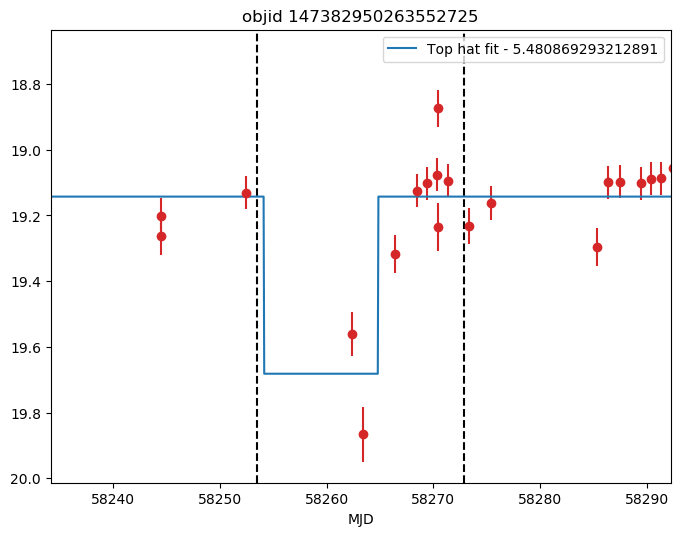

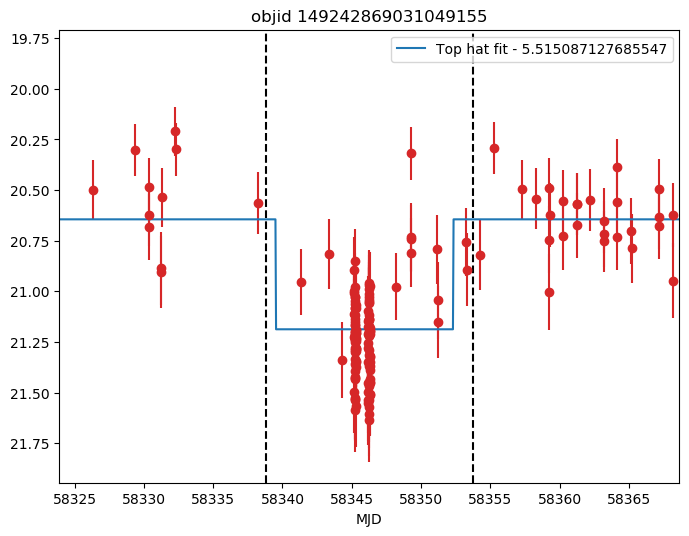

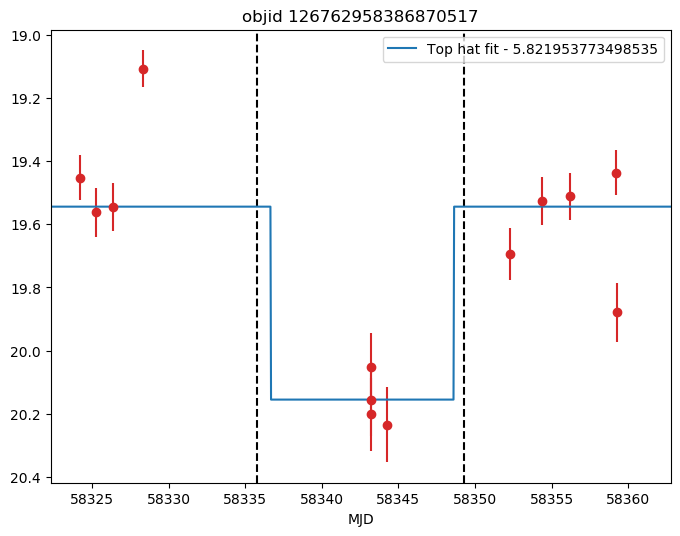

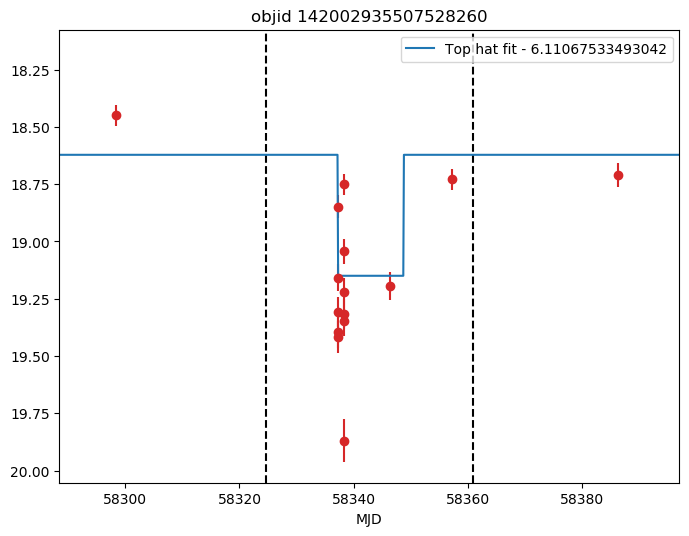

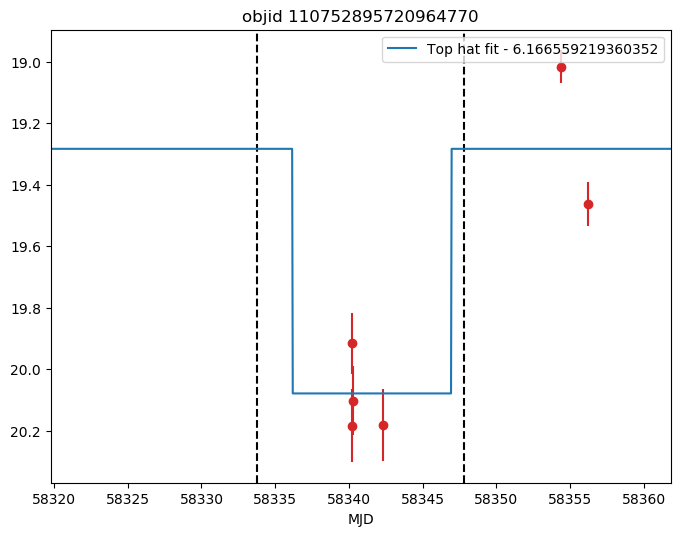

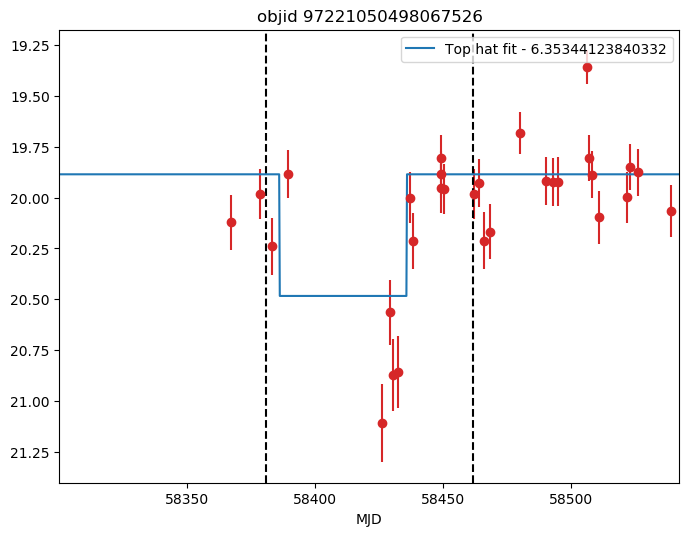

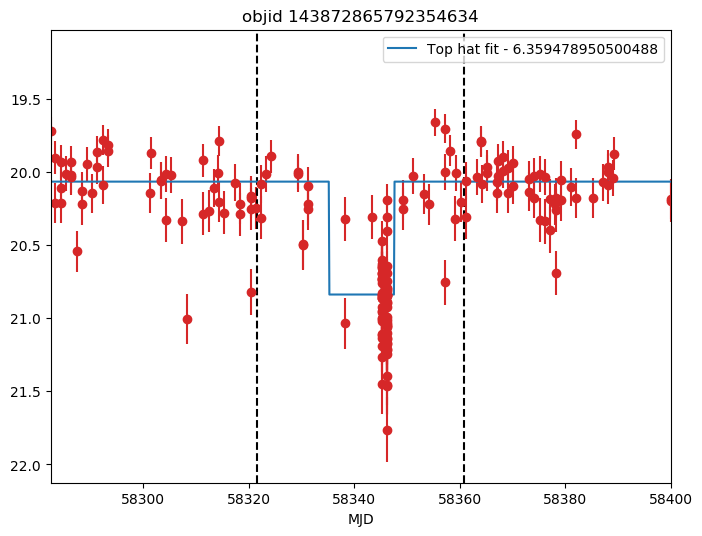

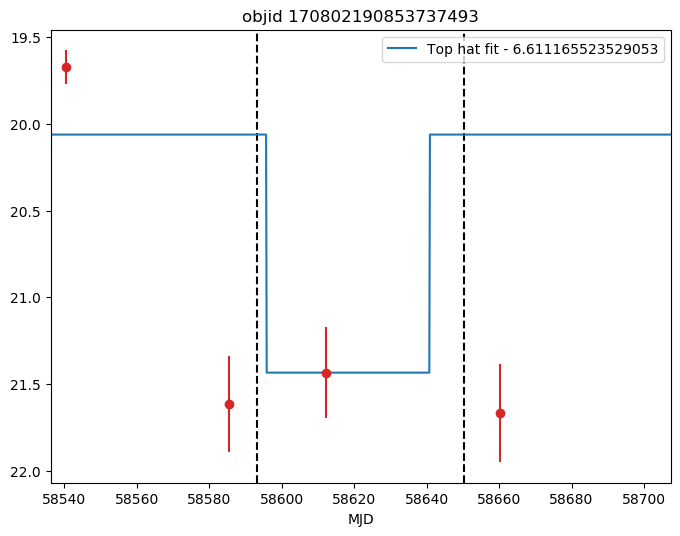

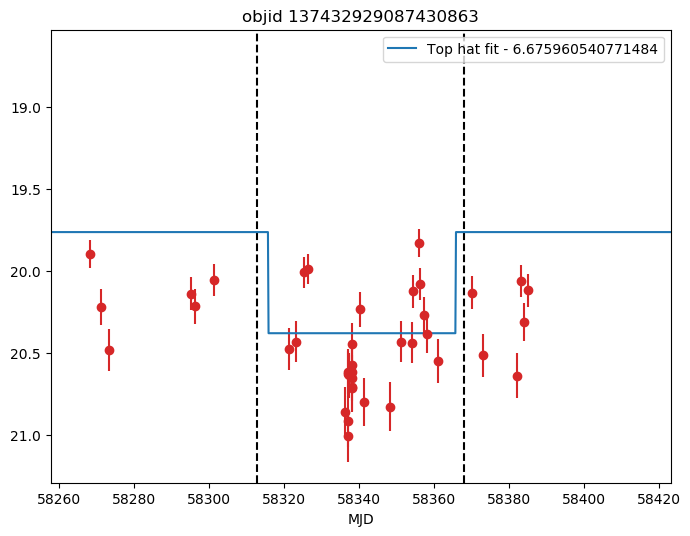

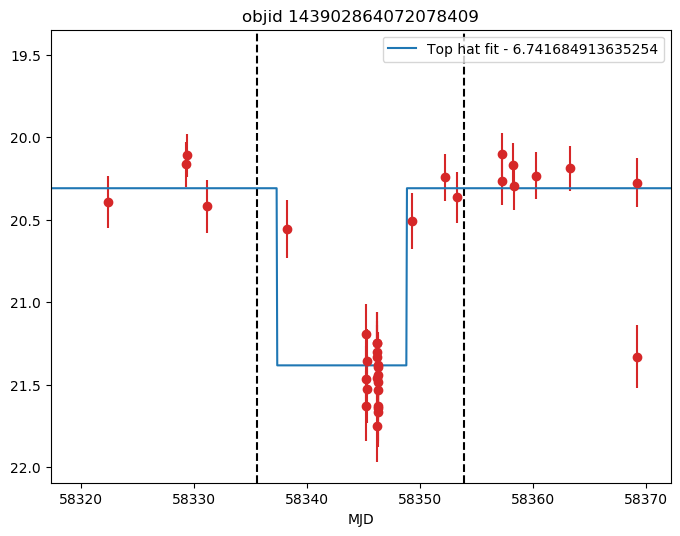

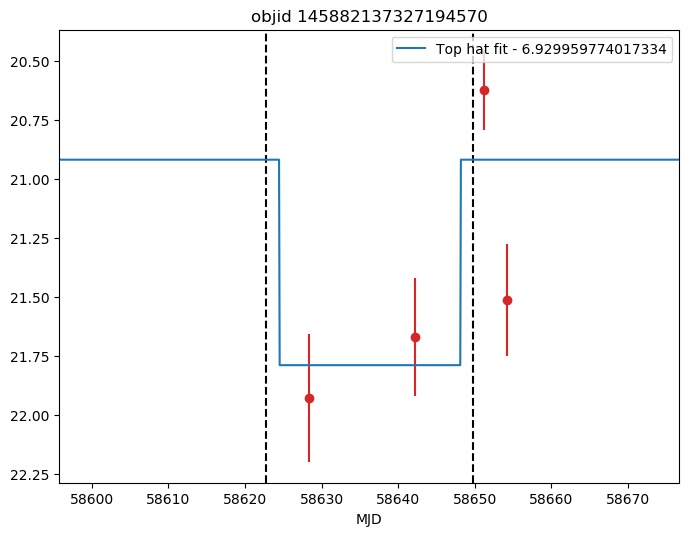

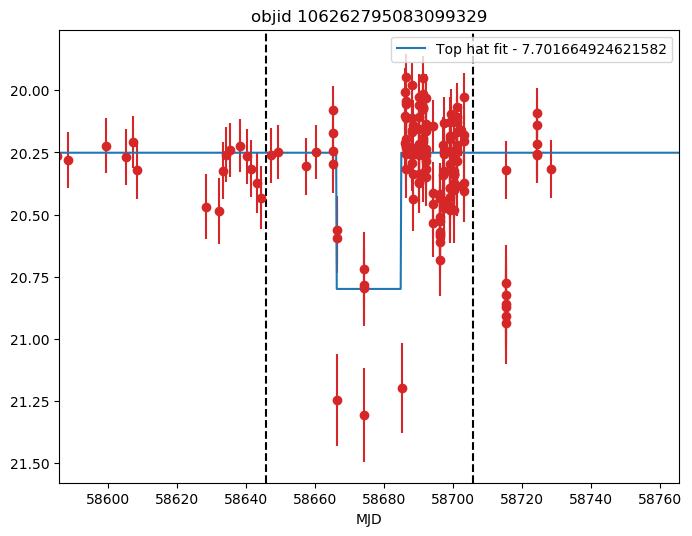

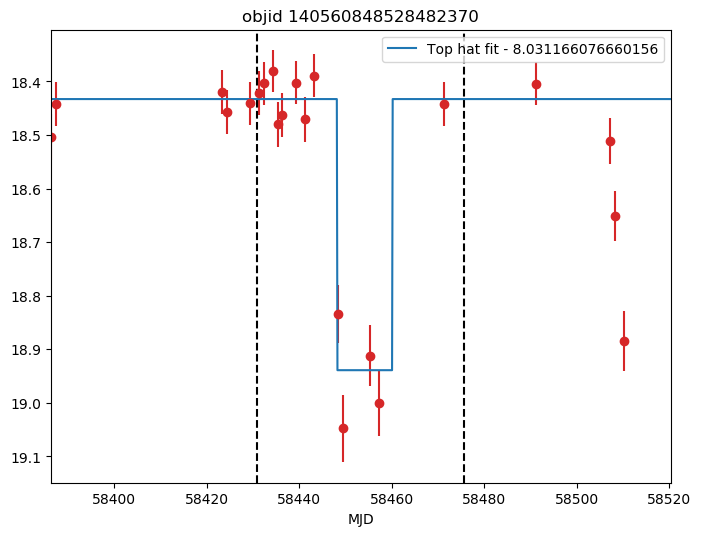

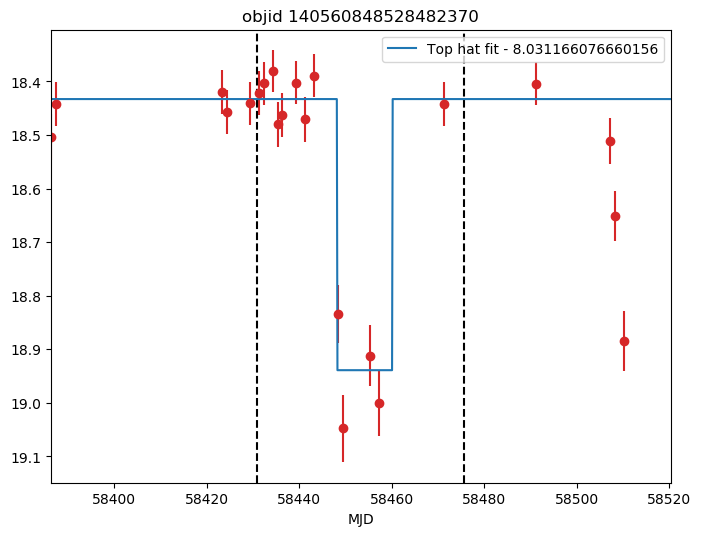

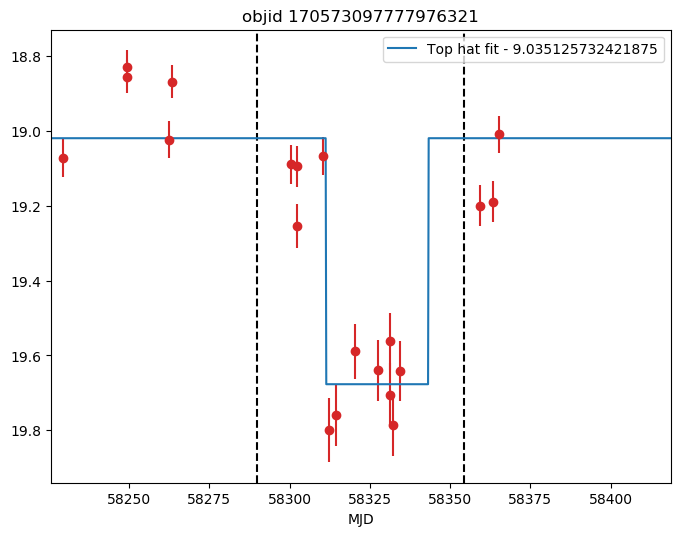

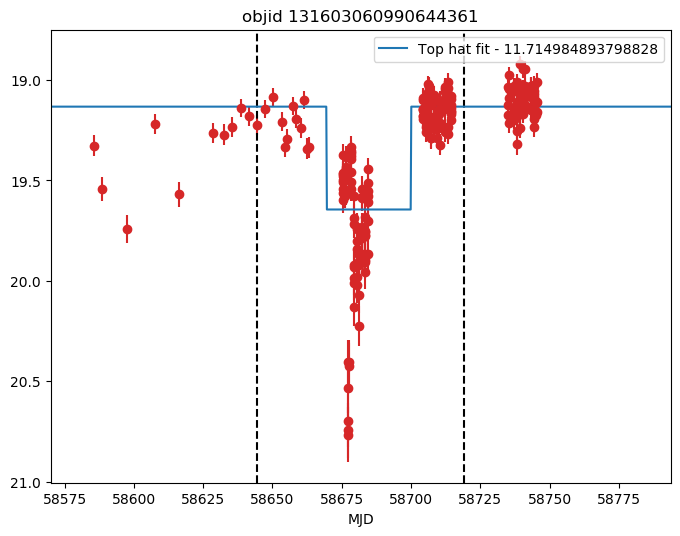

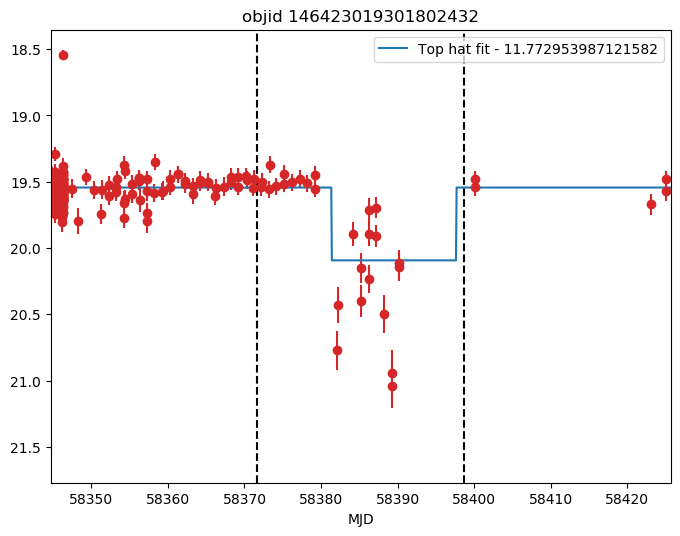

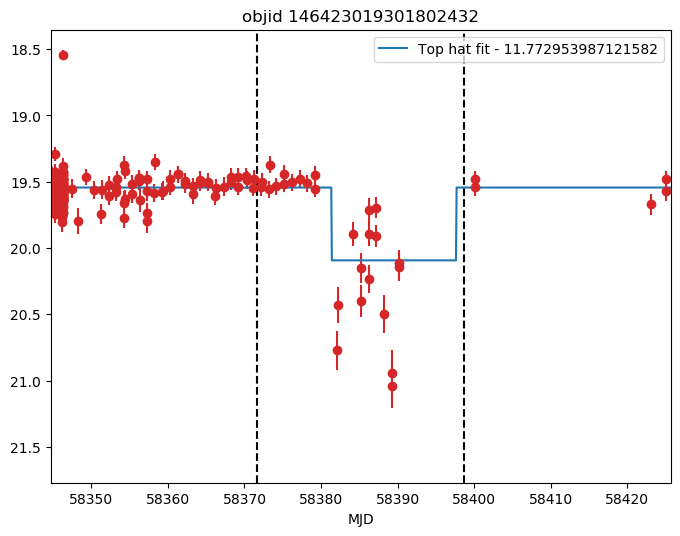

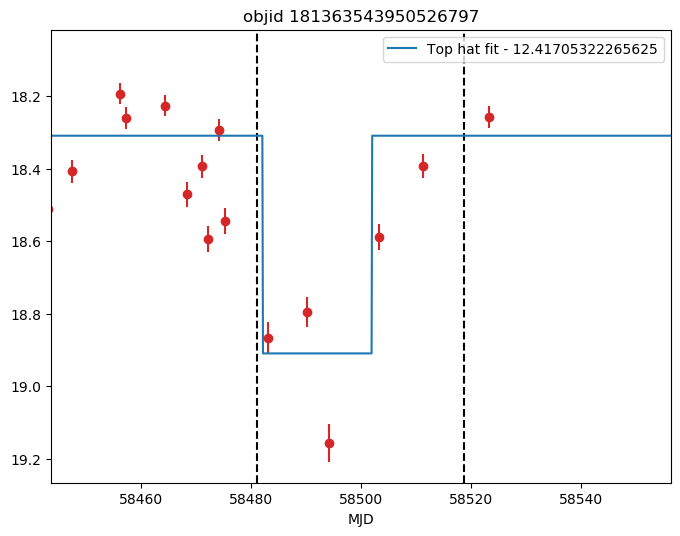

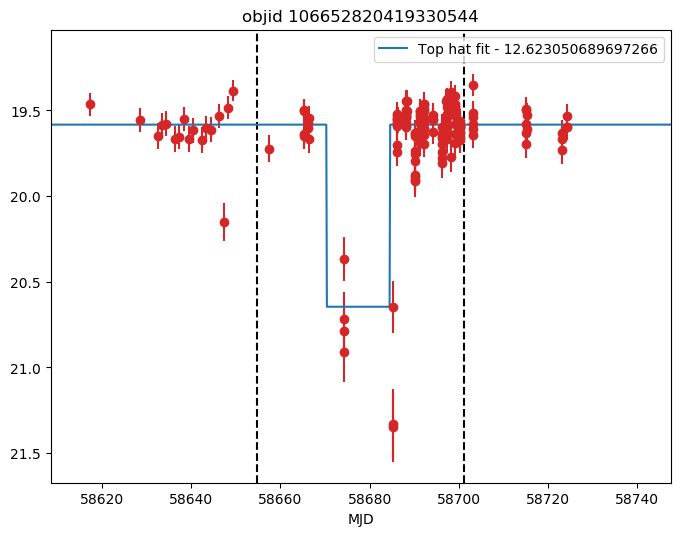

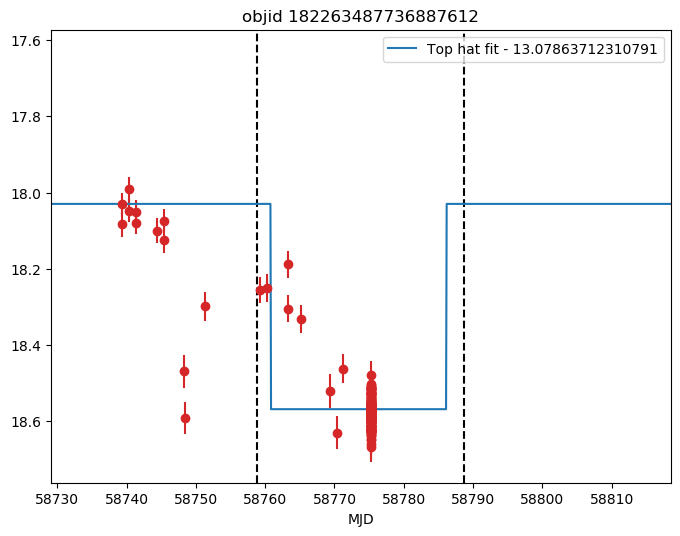

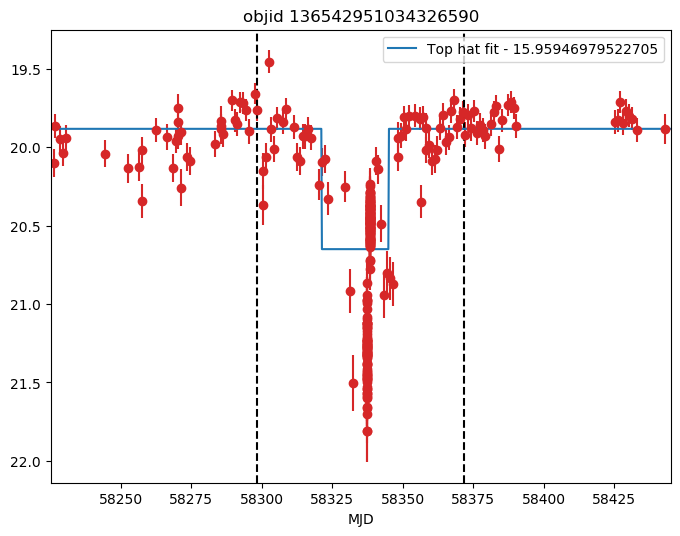

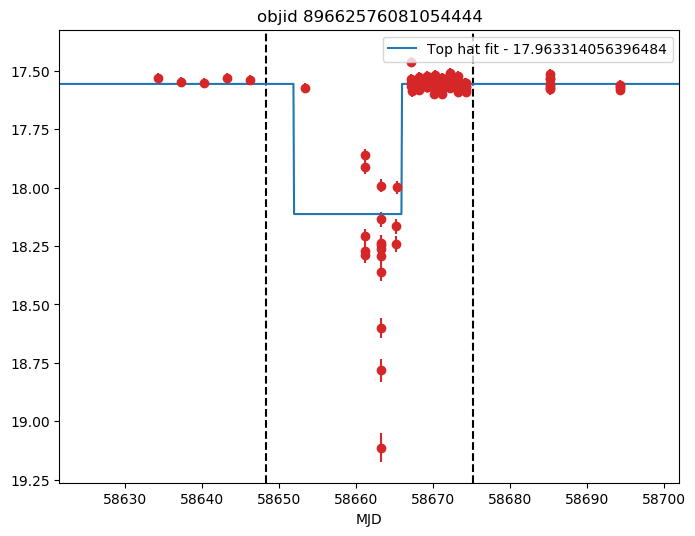

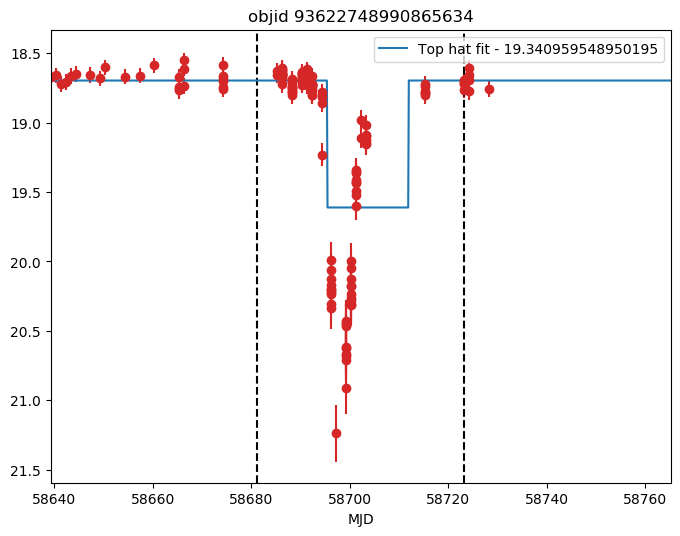

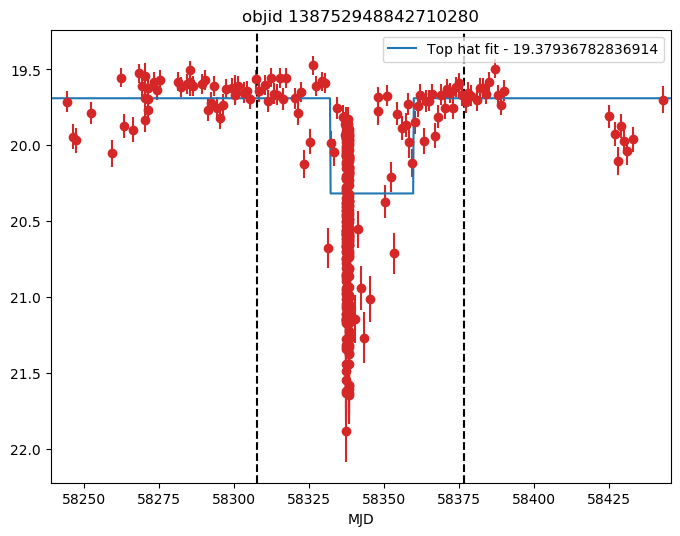

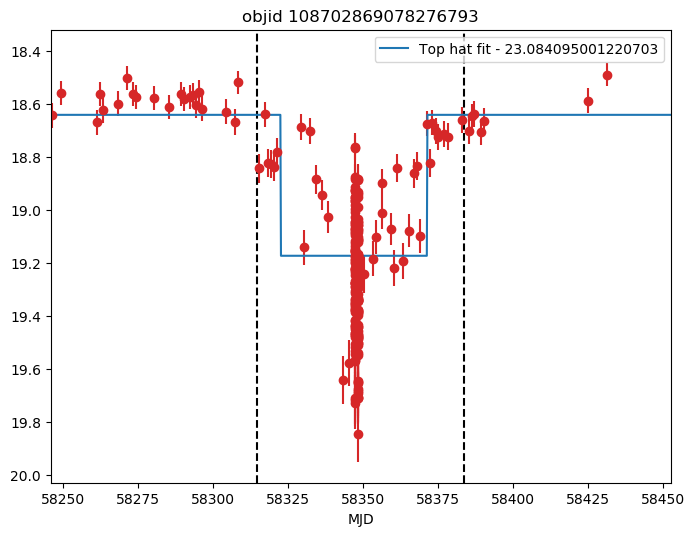

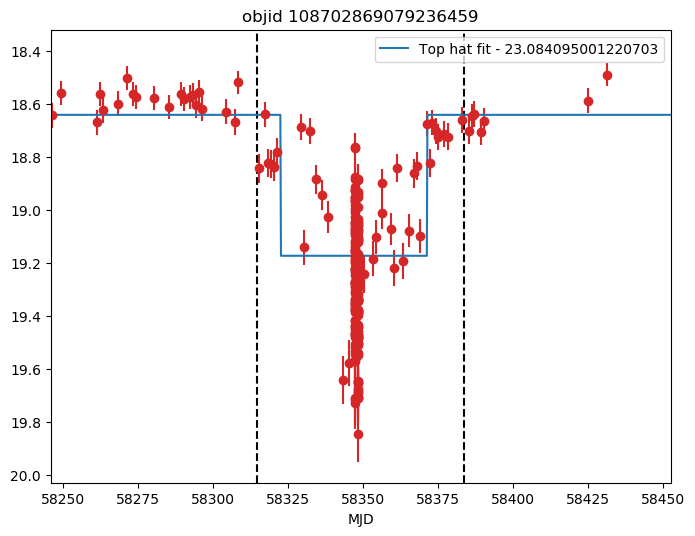

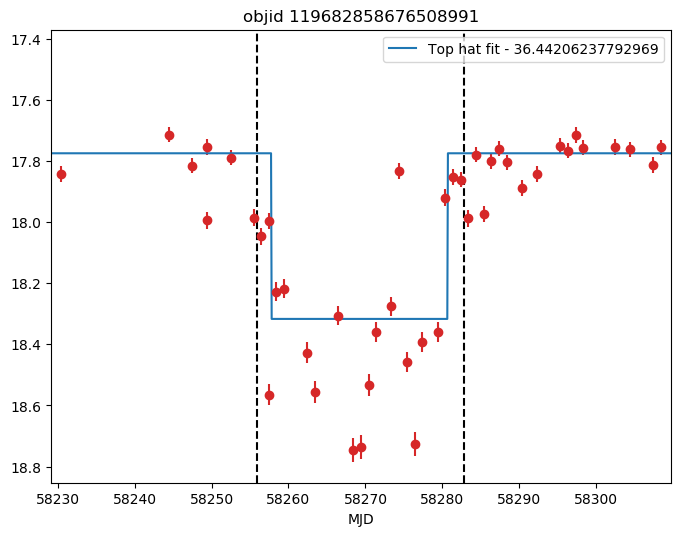

In [77]:
for i in range(top_hat_total):
    plot_top_hat_row(df_top_hat[cut_top_hat].iloc[i])

### Display good top hat fits

In [28]:
cut_list = [
    78502787814267194,
    89342658778647606,
    102812728211929128,
    80302600410459064,
    183882000844600707]

78502787814267194
top hat fit: 5.025500297546387
length: 38.84375

89342658778647606
top hat fit: 5.393836498260498
length: 39.51171875

102812728211929128
top hat fit: 15.431388854980469
length: 37.5078125

80302600410459064
top hat fit: 11.938694953918457
length: 46.34375

183882000844600707
top hat fit: 5.215528964996338
length: 45.765625



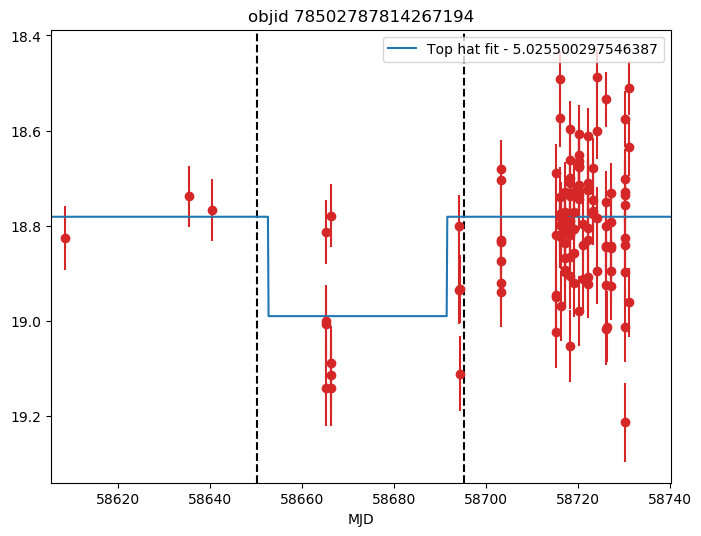

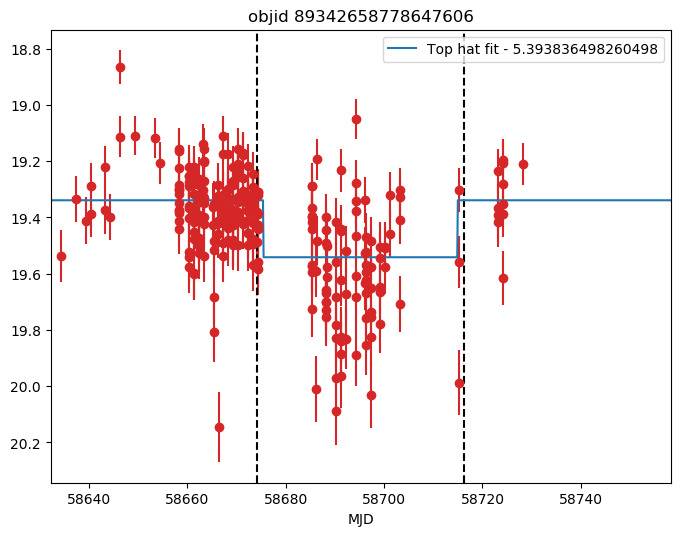

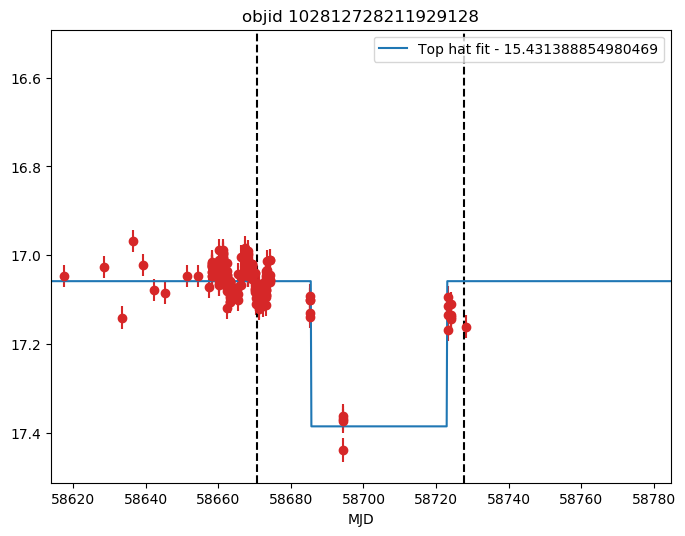

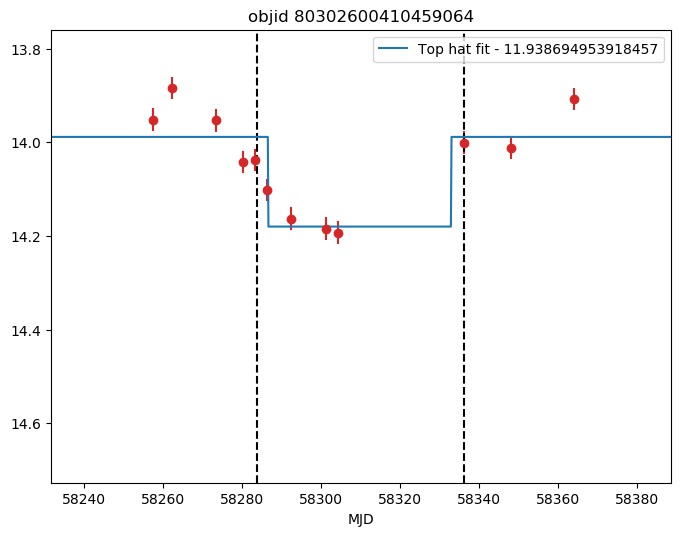

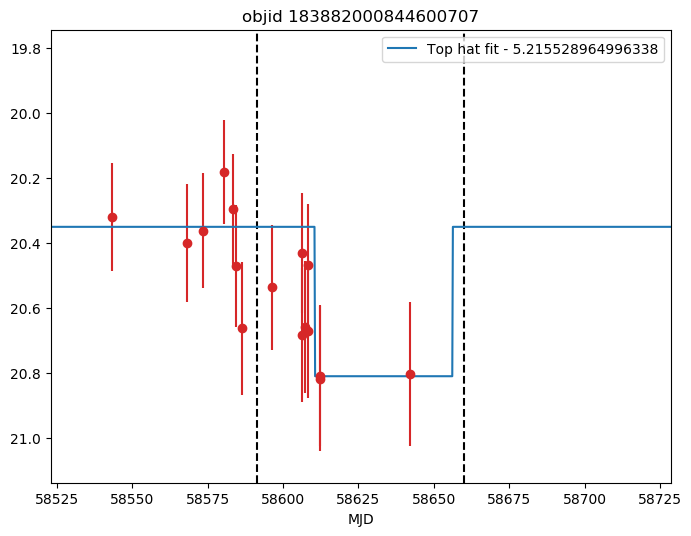

In [30]:
%matplotlib inline
plot_cuts(cut_list, df_top_hat[cut_top_hat])